In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'YAR.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,3573,-2662,911,309,1131,1824,2186,5715,0,...,0,0,598,3204,966,5808,393,-243,275.0,2014-04-25
1,2014-06-30,3887,-2862,1025,397,1008,1590,2372,5585,0,...,0,0,597,3401,958,6075,596,-266,275.0,2014-07-25
2,2014-09-30,3847,-2915,932,265,783,1479,2375,5257,0,...,0,0,613,2964,943,5585,149,-300,275.0,2014-10-25
3,2014-12-31,3770,-2758,1012,294,481,1619,2495,5162,0,...,0,0,643,2902,1420,6406,227,-386,275.0,2015-02-09
4,2015-03-31,3570,-2550,1020,109,494,1691,2335,5002,0,...,0,0,376,2633,1235,5872,698,-260,274.0,2015-04-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-04-25,254.00,4136,-3282,854,105,1188,2096,4039,...,132,17652,0,173,175,3863,3576,8915,503,-269
37,2023-06-30,2023-07-25,254.00,3940,-3286,654,-298,626,1944,3338,...,132,16211,0,477,159,3963,3550,9032,677,-270
38,2023-09-30,2023-10-25,254.00,3850,-3054,796,2,868,1710,2794,...,129,15665,0,141,160,3515,3518,8523,1015,-299
39,2023-12-31,2024-02-09,254.00,3582,-2473,1109,246,539,1634,3058,...,135,16027,0,517,123,3714,3284,8457,93,-373
40,2024-03-31,2024-04-22,254.73,3315,-2447,868,16,328,1883,2841,...,134,15660,1818,424,140,3520,3238,8238,58,-260


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-25,254.00,4136,-3282,854,105,1188,2096,4039,...,17652,0,173,175,3863,3576,8915,503,-269,10.221379
37,2023-06-30,2023-07-25,254.00,3940,-3286,654,-298,626,1944,3338,...,16211,0,477,159,3963,3550,9032,677,-270,10.699984
38,2023-09-30,2023-10-25,254.00,3850,-3054,796,2,868,1710,2794,...,15665,0,141,160,3515,3518,8523,1015,-299,10.483742
39,2023-12-31,2024-02-09,254.00,3582,-2473,1109,246,539,1634,3058,...,16027,0,517,123,3714,3284,8457,93,-373,10.821103
40,2024-03-31,2024-04-22,254.73,3315,-2447,868,16,328,1883,2841,...,15660,1818,424,140,3520,3238,8238,58,-260,10.502364


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-25,254.00,42275.621929,-33546.564597,8729.057333,1073.244754,12142.997788,21424.009566,41284.148204,...,180427.775216,0.000000,1768.298499,1788.741257,39485.185569,36551.649908,91123.590304,5141.353441,-2749.550846,10.221379
37,2023-06-30,2023-07-25,254.00,42157.935782,-35160.146442,6997.789341,-3188.595143,6698.189797,20800.768315,35716.545594,...,173457.435779,0.000000,5103.892225,1701.297408,42404.035407,37984.942139,96642.252788,7243.888966,-2888.995599,10.699984
38,2023-09-30,2023-10-25,254.00,40362.406850,-32017.348187,8345.058663,20.967484,9099.888090,17927.198887,29291.575257,...,164227.819041,0.000000,1478.207628,1677.398726,36850.353267,36881.804493,89352.933399,10640.998170,-3134.638870,10.483742
39,2023-12-31,2024-02-09,254.00,38761.190764,-26760.587594,12000.603171,2661.991326,5832.574490,17681.682219,33090.932819,...,173429.816968,0.000000,5594.510225,1330.995663,40189.576354,35536.502085,91514.067642,1006.362574,-4036.271400,10.821103
40,2024-03-31,2024-04-22,254.73,34815.336213,-25699.284378,9116.051835,168.037822,3444.775348,19775.951158,29837.215741,...,164467.018129,19093.297507,4453.002279,1470.330941,36968.320805,34006.654195,86518.473521,609.137104,-2730.614605,10.502364


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-28,149.858643,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.610619,0.389381,0.0,0.0,0.0,0.0,0.254968,0.086482,0.0,0.0
1,2014-05-05,146.593857,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.610619,0.389381,0.0,0.0,0.0,0.0,0.254968,0.086482,0.0,0.0
2,2014-05-12,155.877823,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.610619,0.389381,0.0,0.0,0.0,0.0,0.254968,0.086482,0.0,0.0
3,2014-05-19,154.323517,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.610619,0.389381,0.0,0.0,0.0,0.0,0.254968,0.086482,0.0,0.0
4,2014-05-26,151.547913,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.610619,0.389381,0.0,0.0,0.0,0.0,0.254968,0.086482,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-28,149.858643,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.0,0.254968,0.086482,0.0,0.0,inf,0.742727,0.473325,0.800571,inf
1,2014-05-05,146.593857,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.0,0.254968,0.086482,0.0,0.0,inf,0.726546,0.463013,0.790259,inf
2,2014-05-12,155.877823,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.0,0.254968,0.086482,0.0,0.0,inf,0.772559,0.492336,0.819582,inf
3,2014-05-19,154.323517,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.0,0.254968,0.086482,0.0,0.0,inf,0.764856,0.487427,0.814673,inf
4,2014-05-26,151.547913,2014-03-31,21766.834437,0.0,201.768138,275.0,0.0,0.0,6890.08949,...,0.0,0.254968,0.086482,0.0,0.0,inf,0.751099,0.478660,0.805906,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

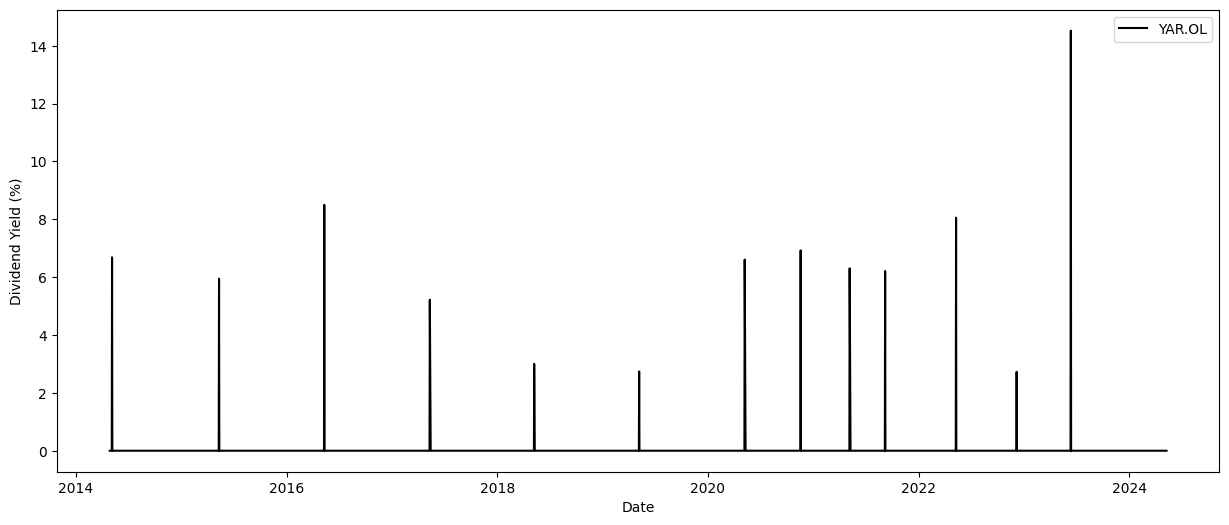

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.725625
share_price      1.000000
Name: share_price, dtype: float64


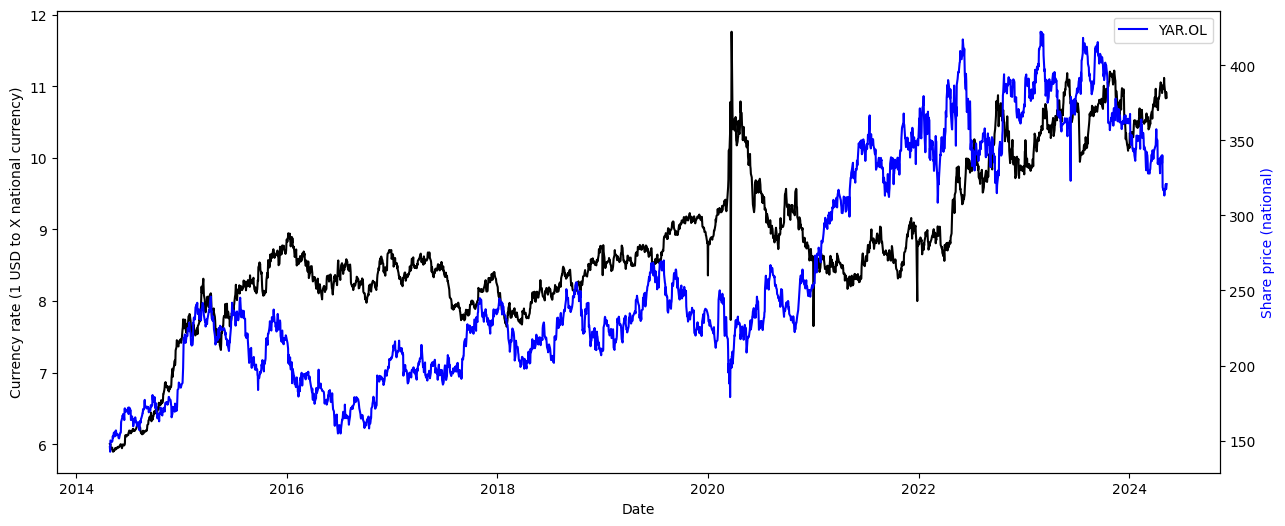

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

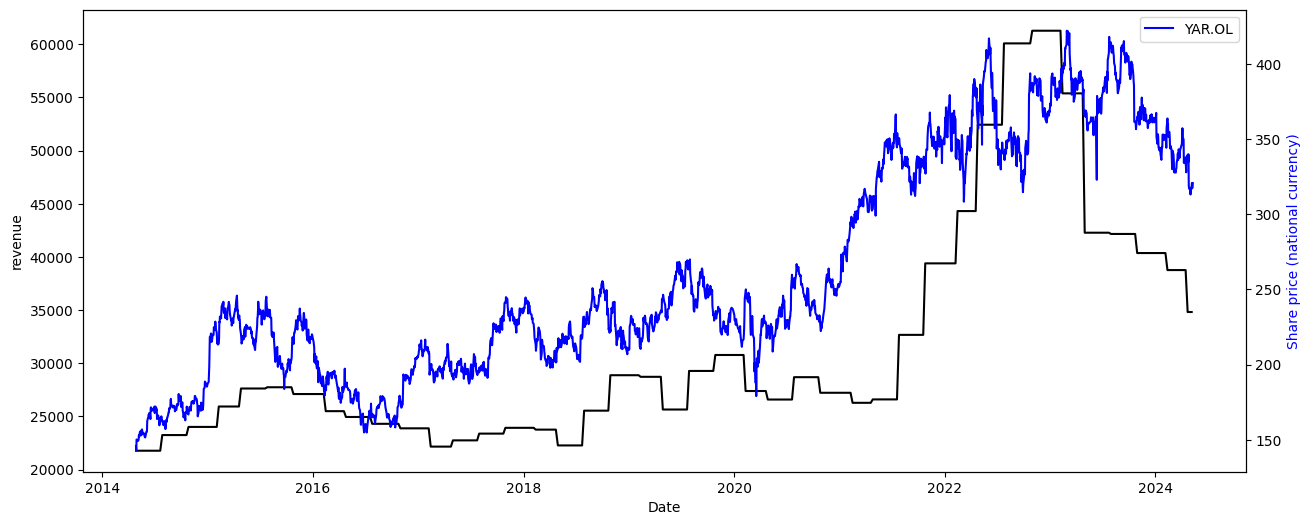

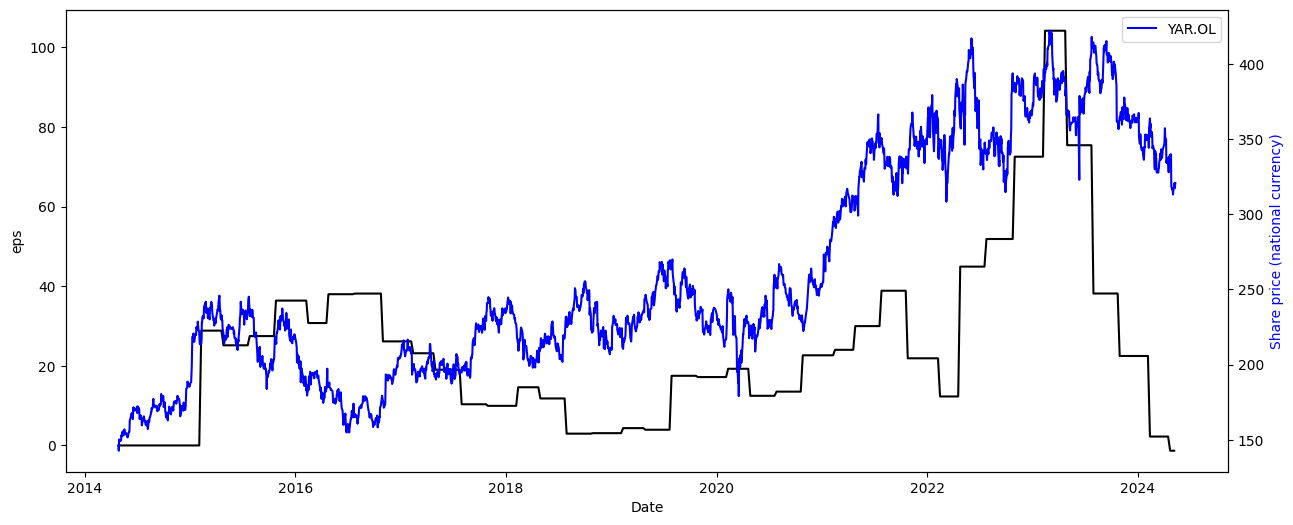

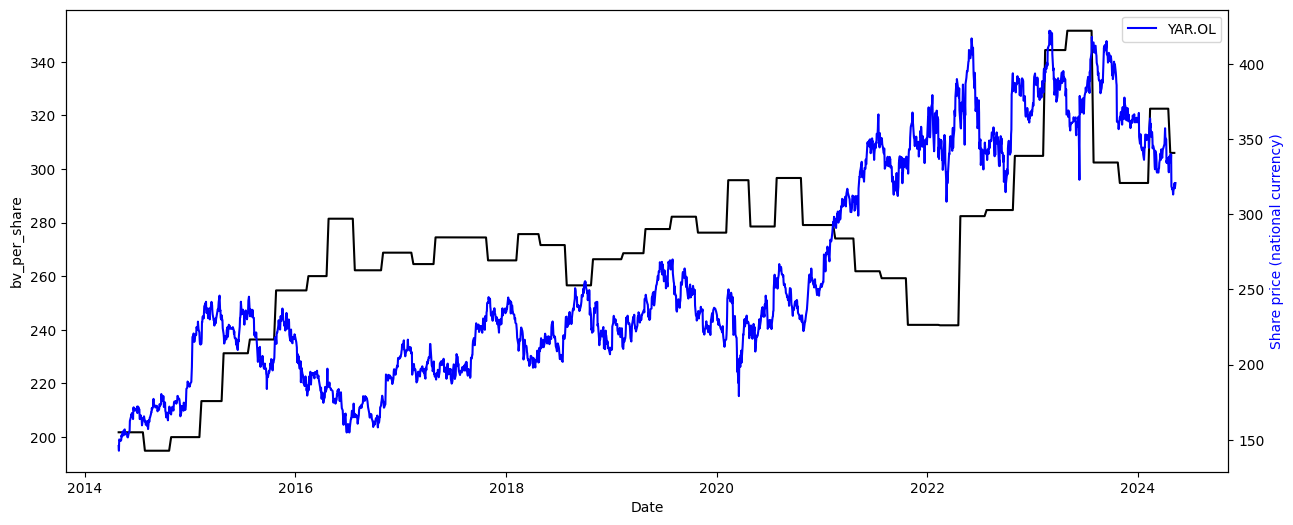

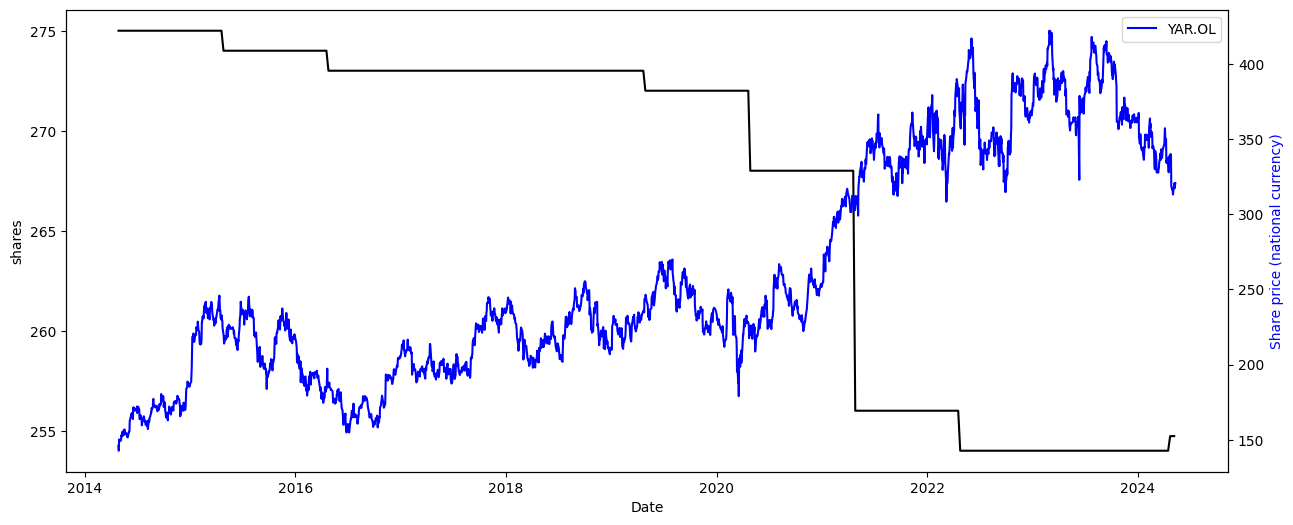

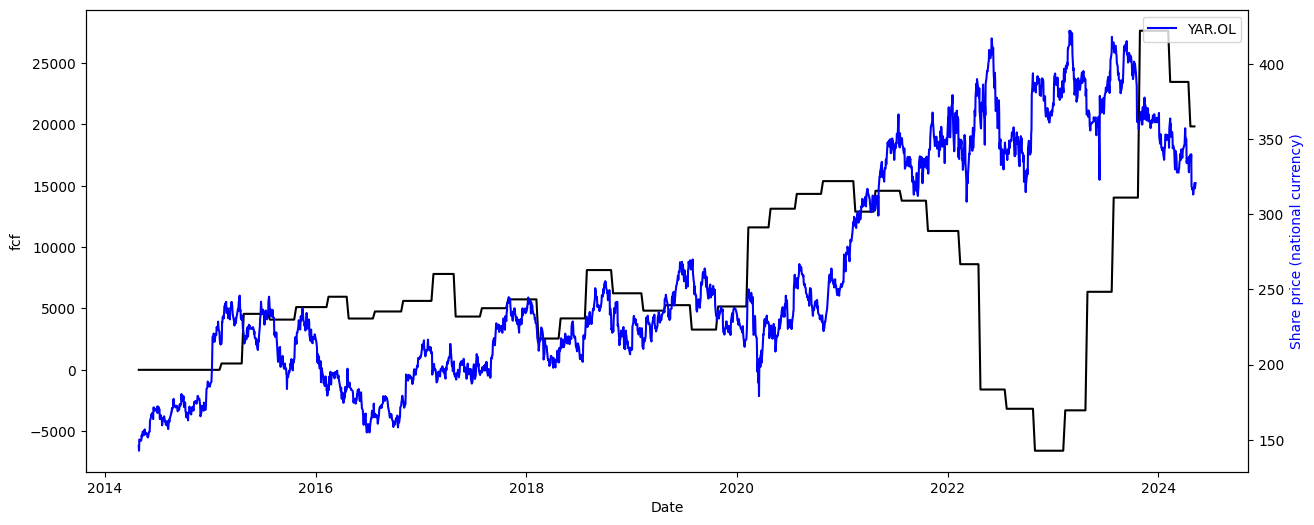

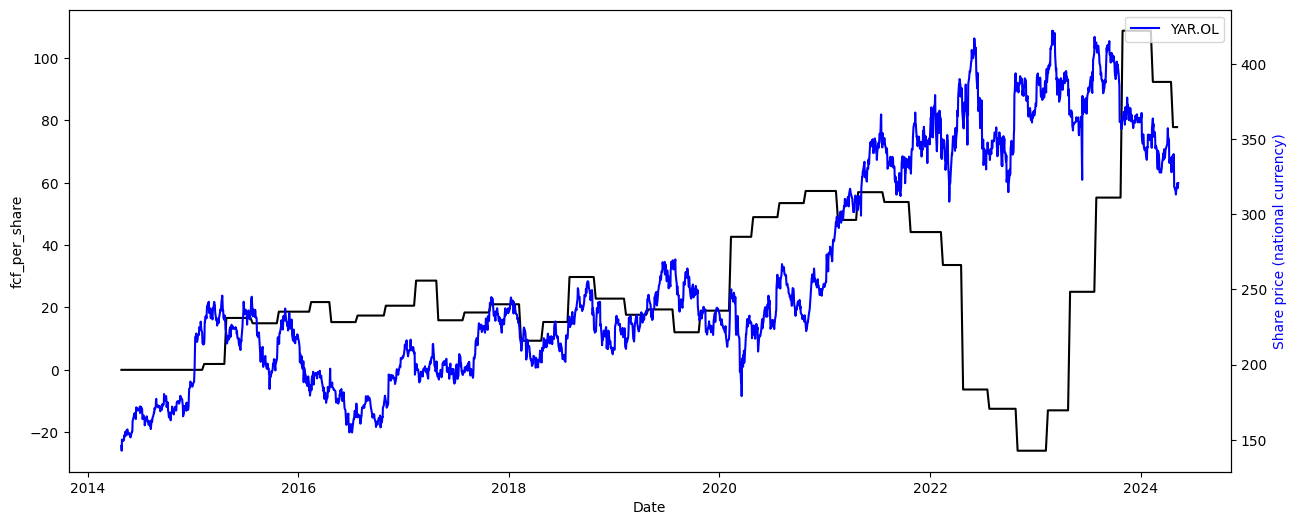

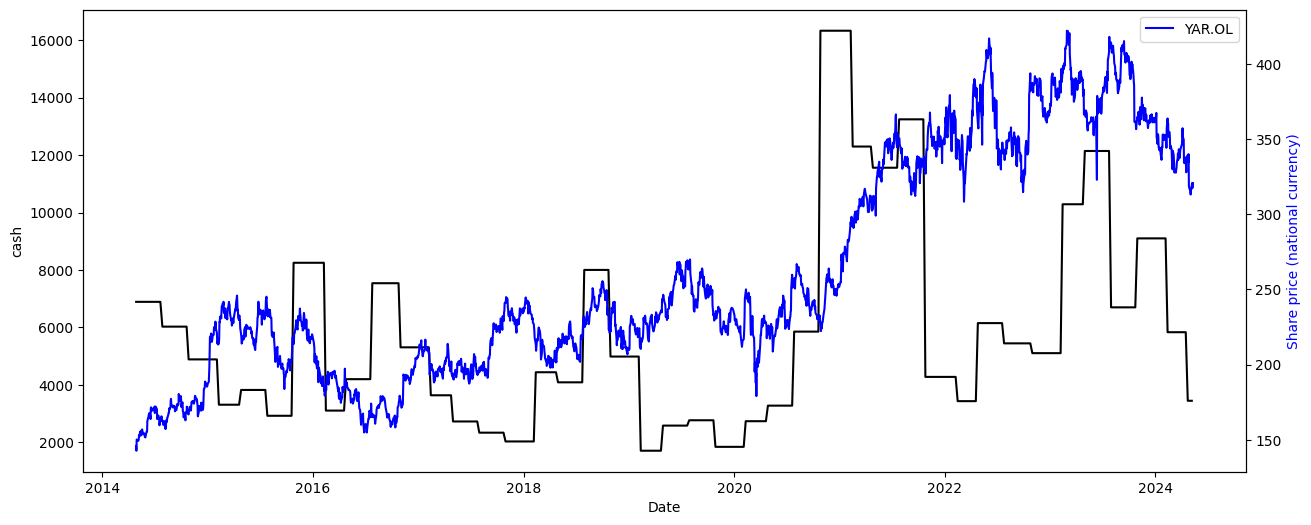

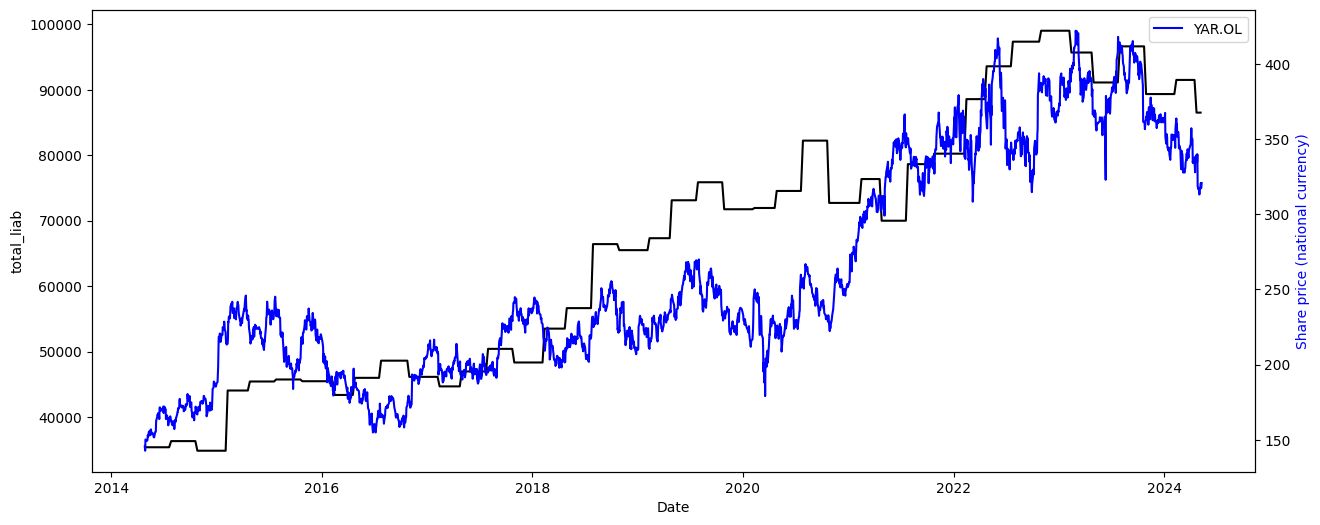

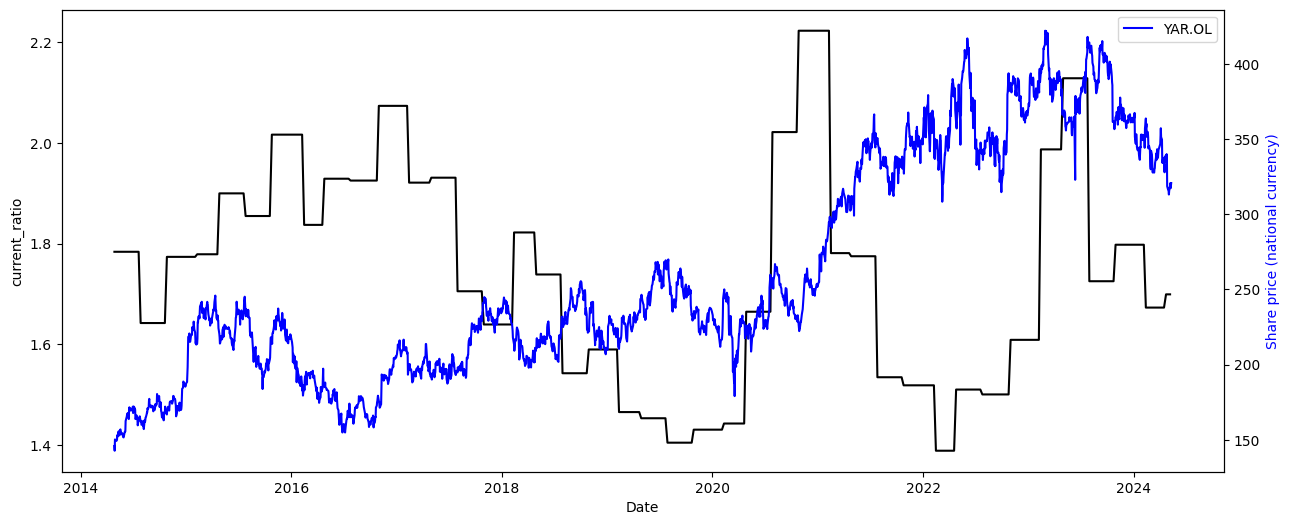

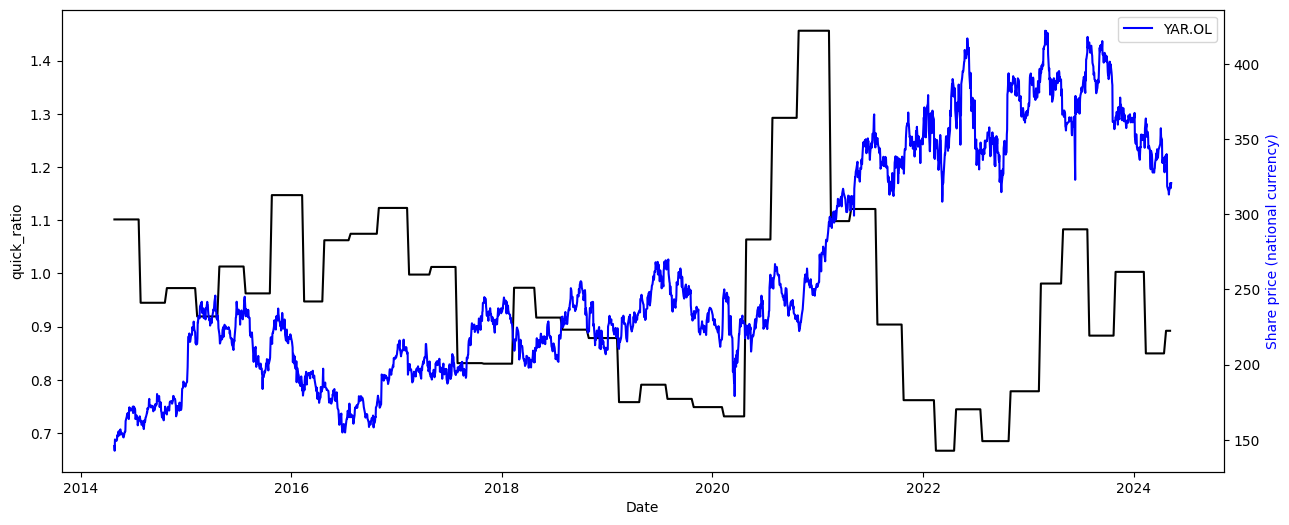

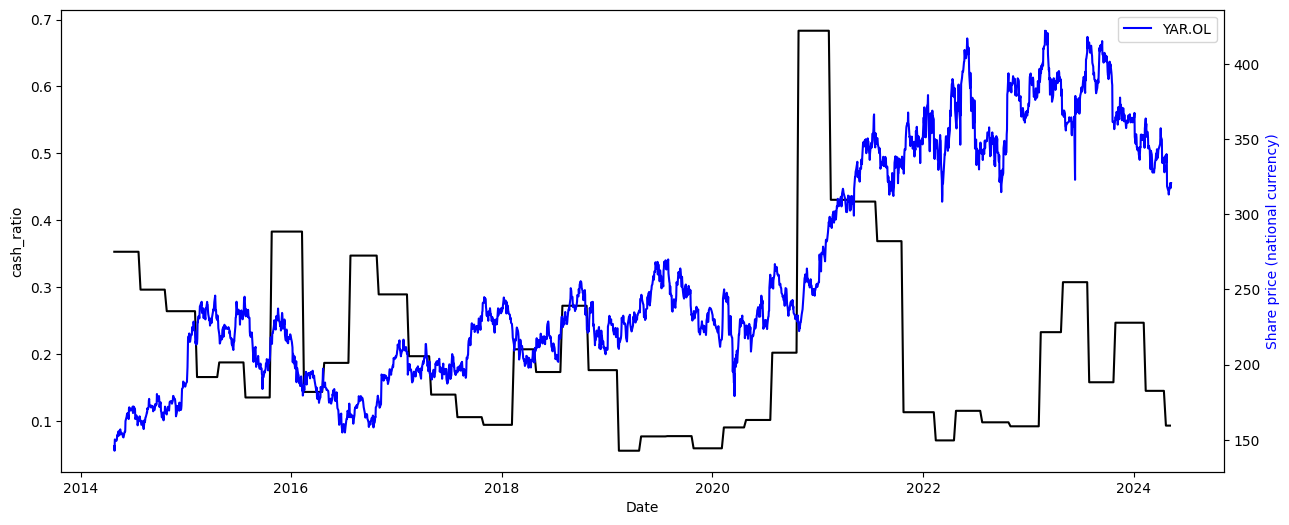

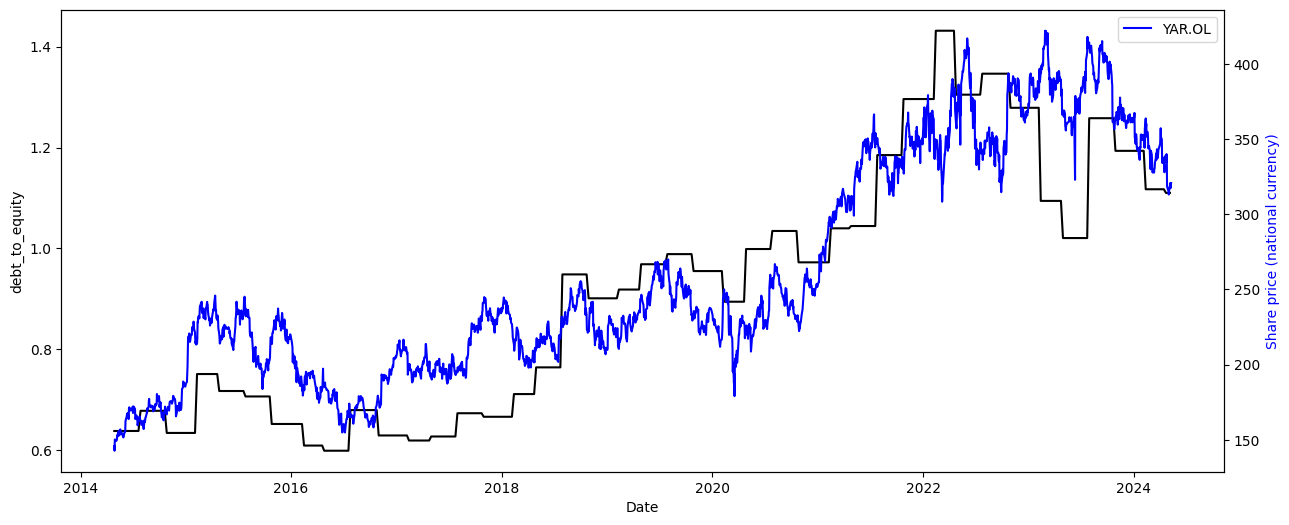

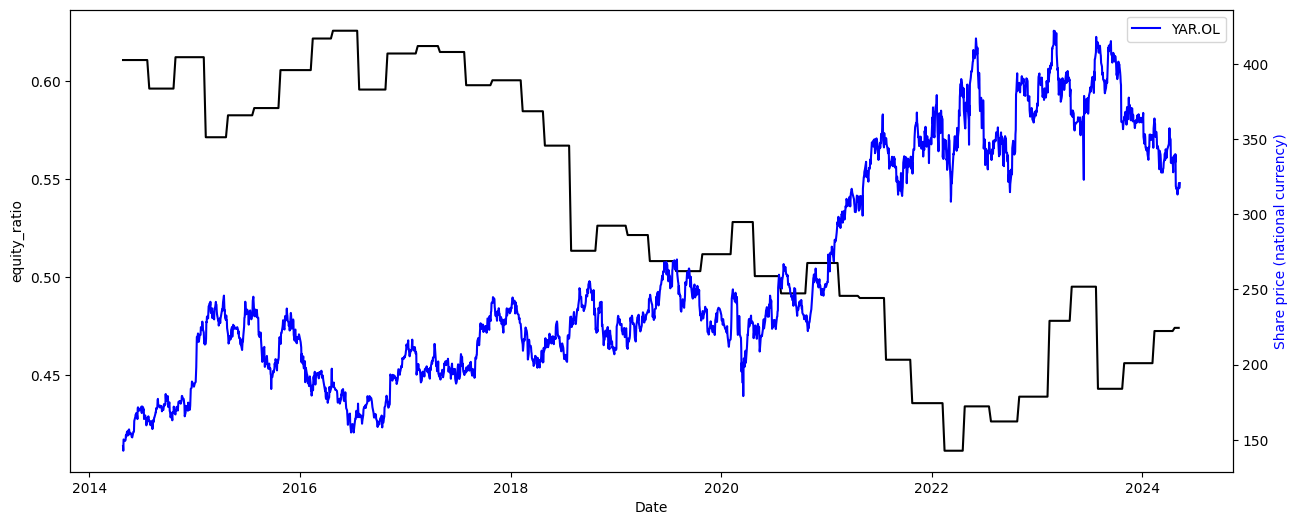

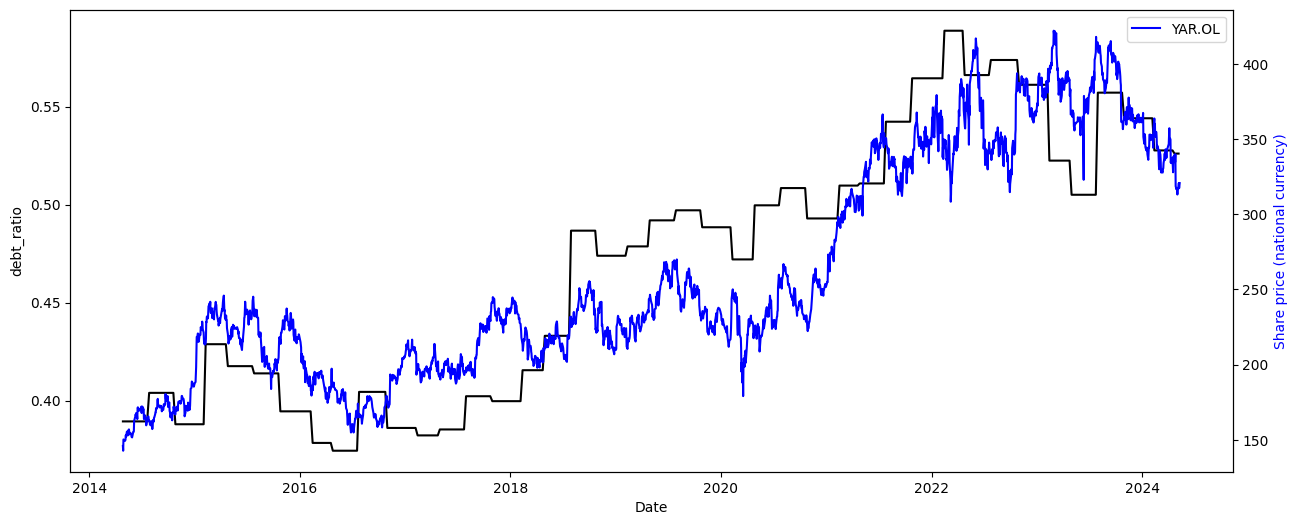

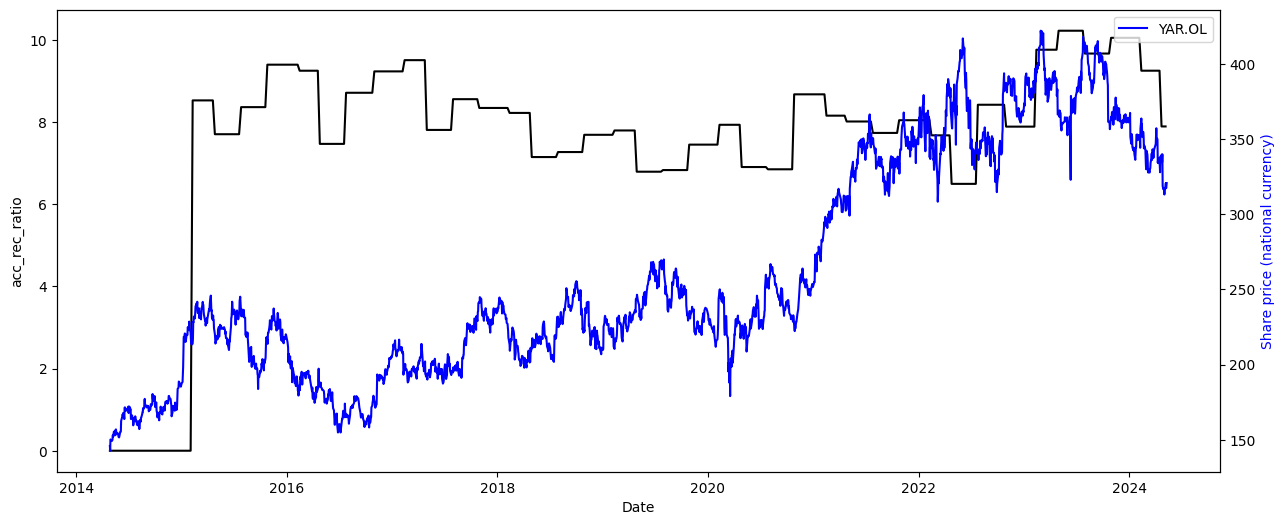

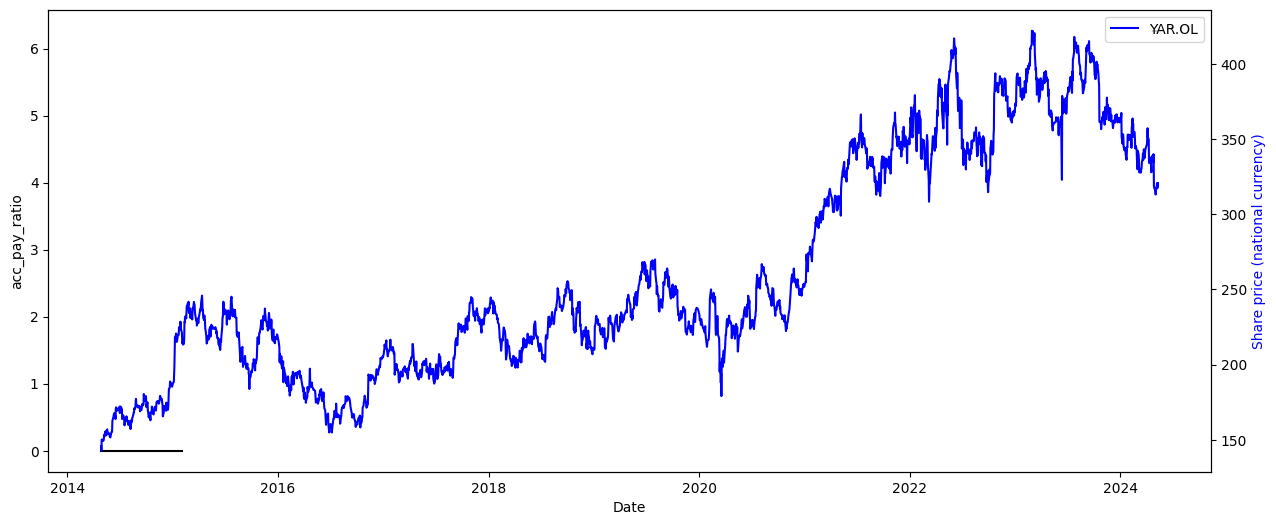

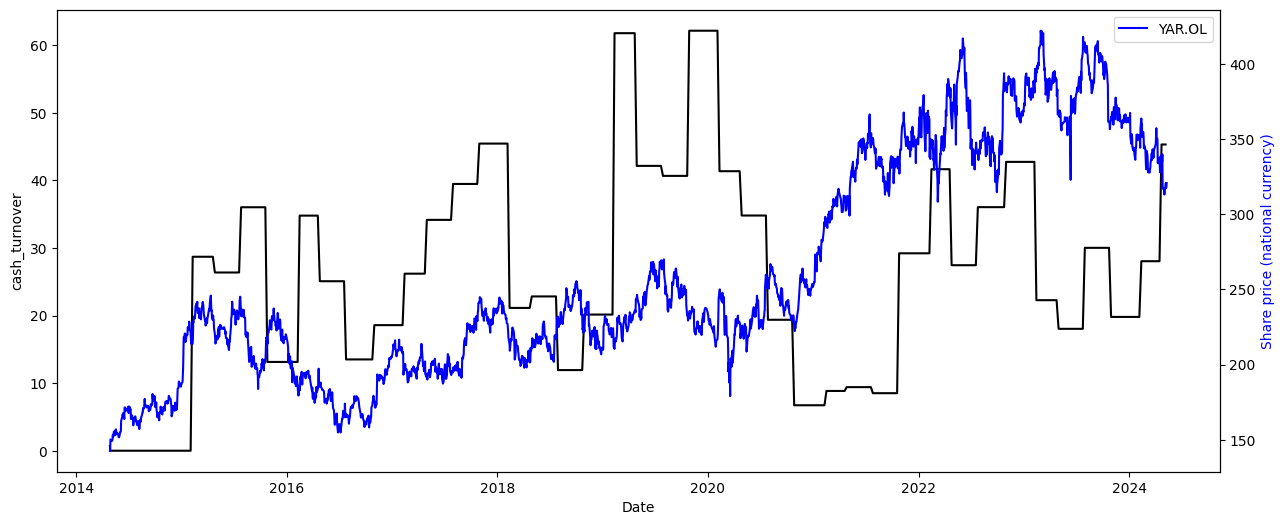

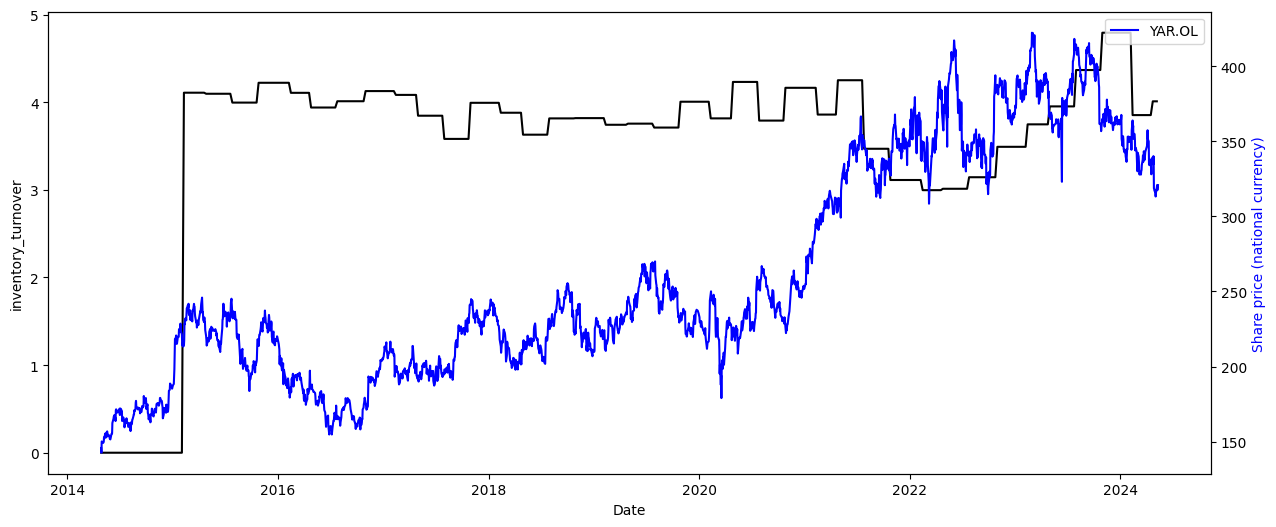

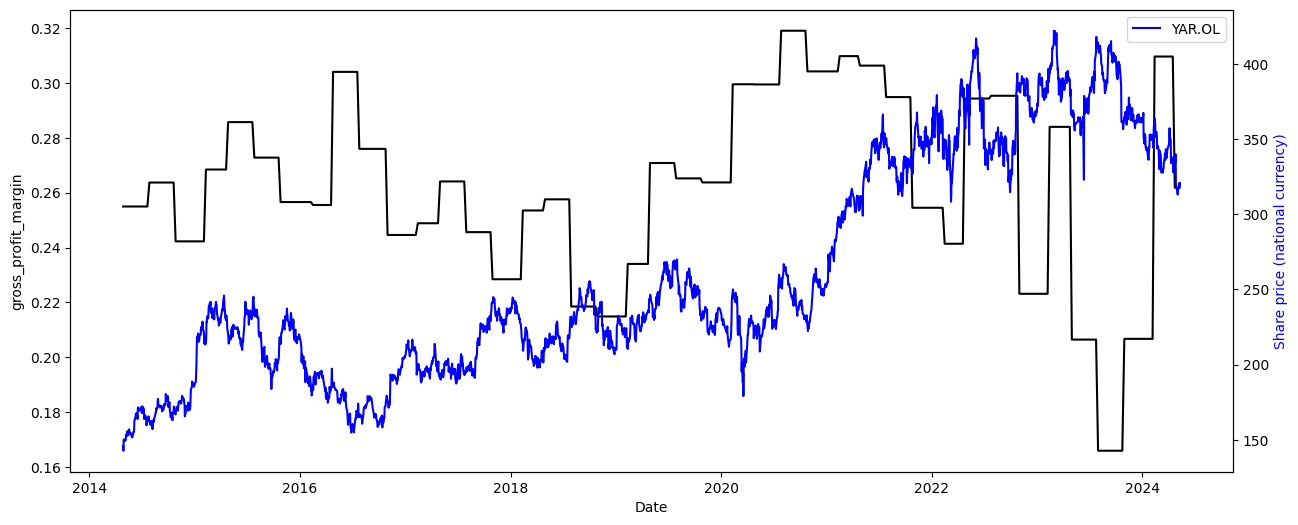

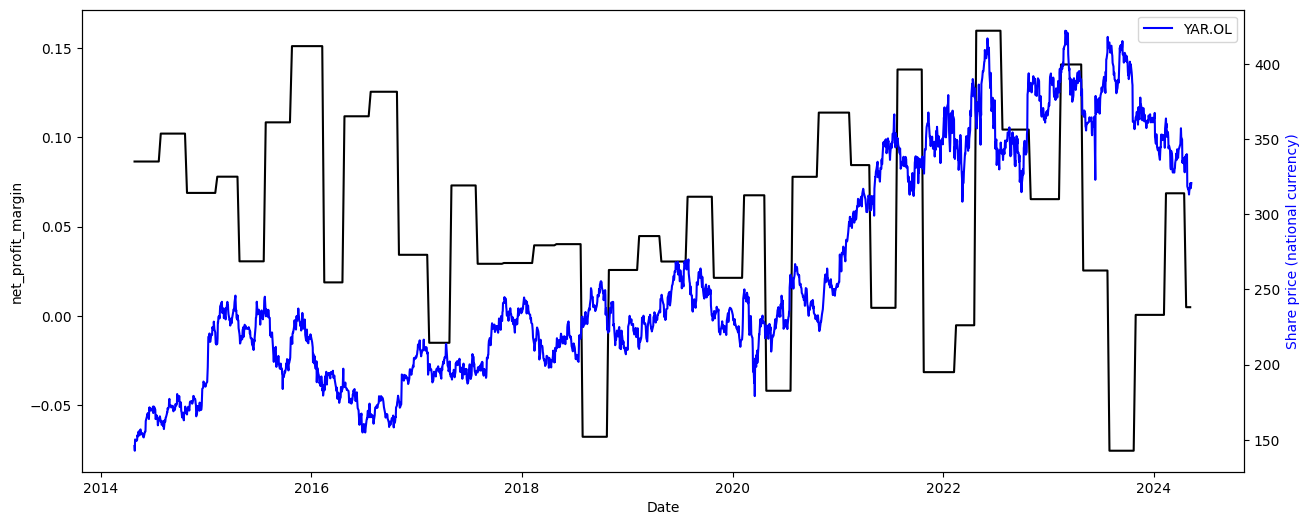

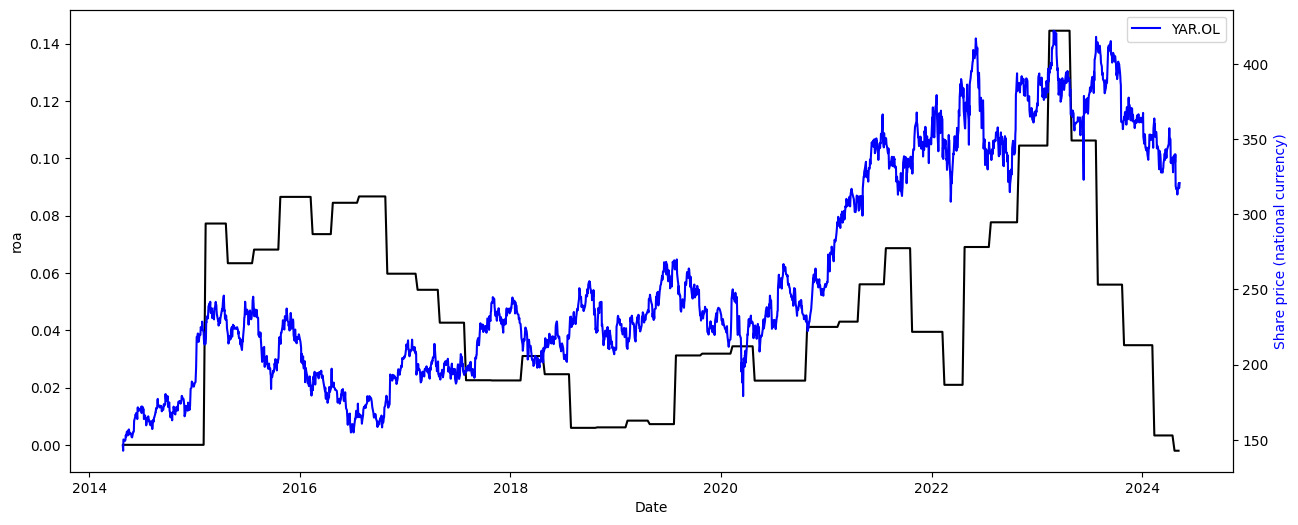

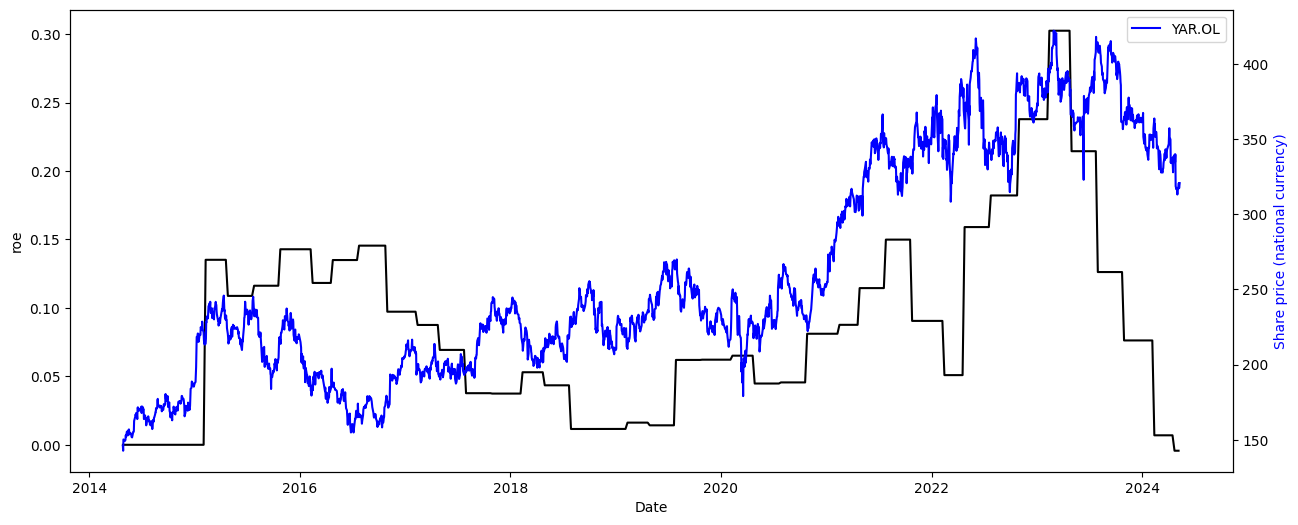

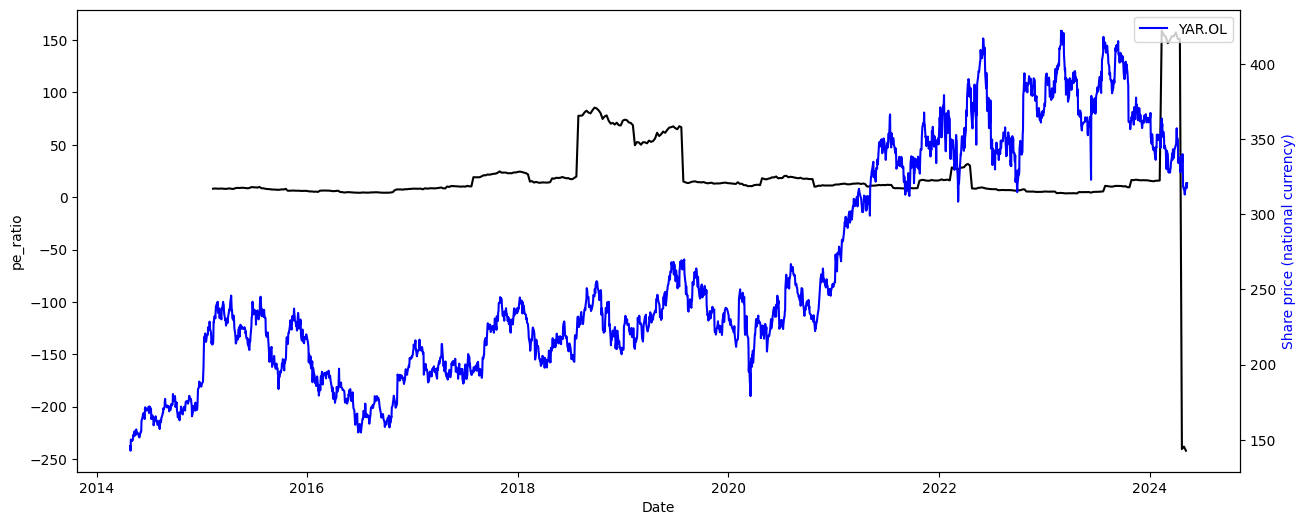

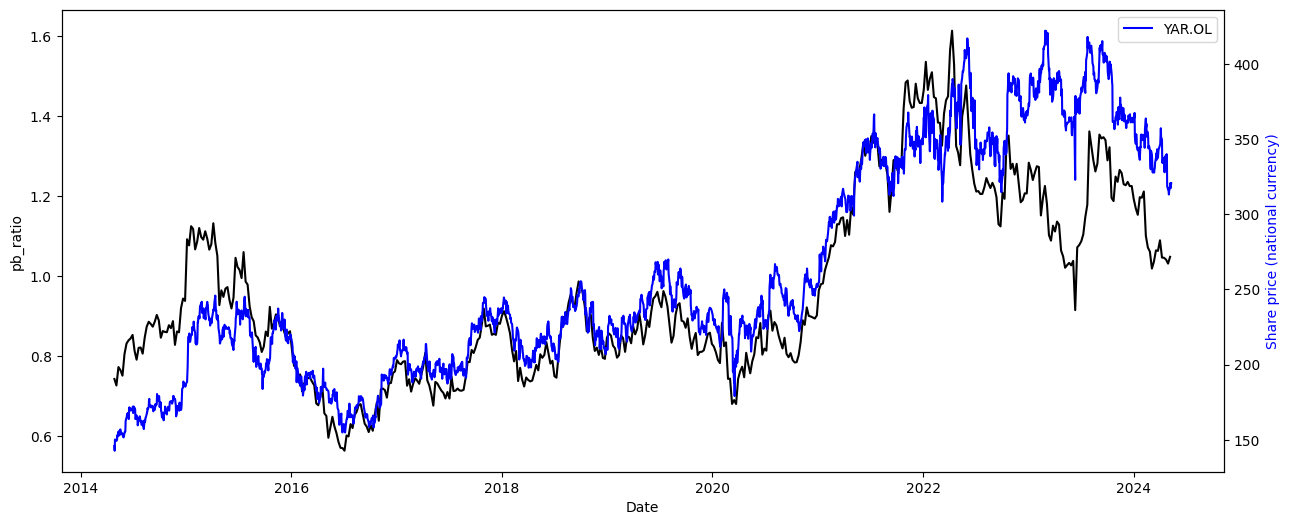

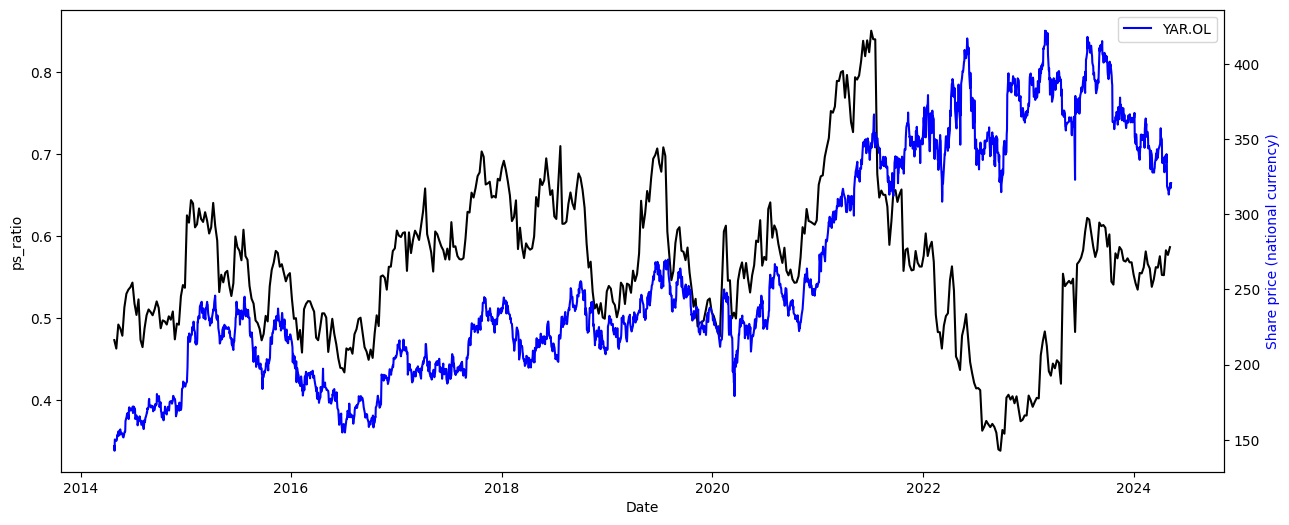

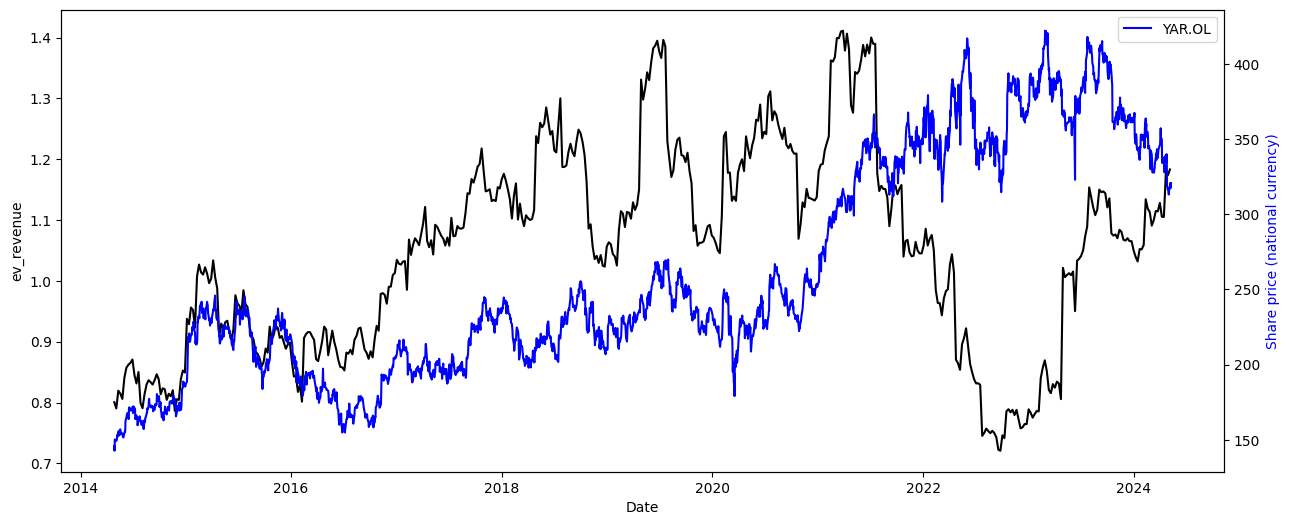

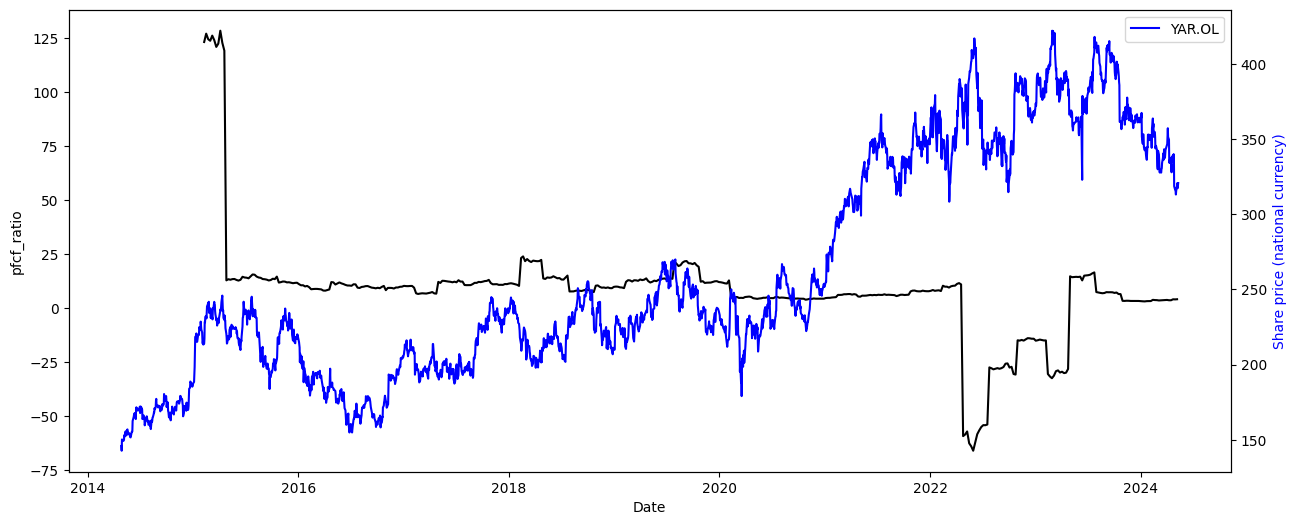

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

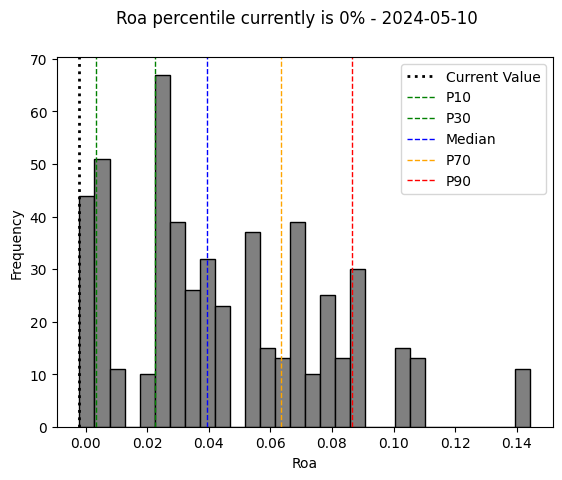

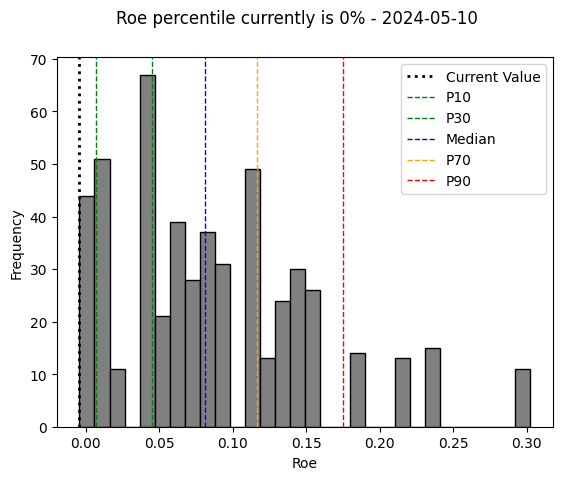

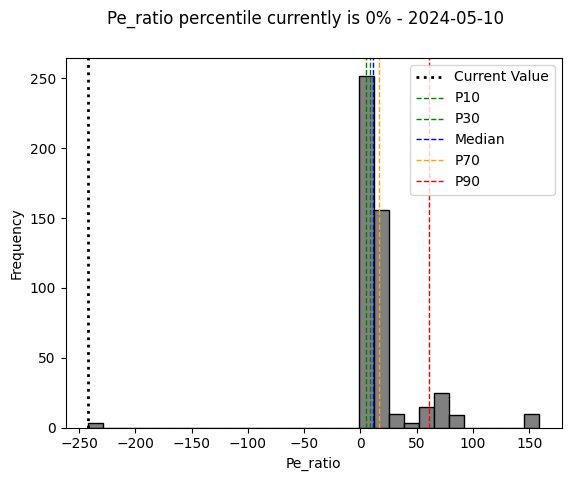

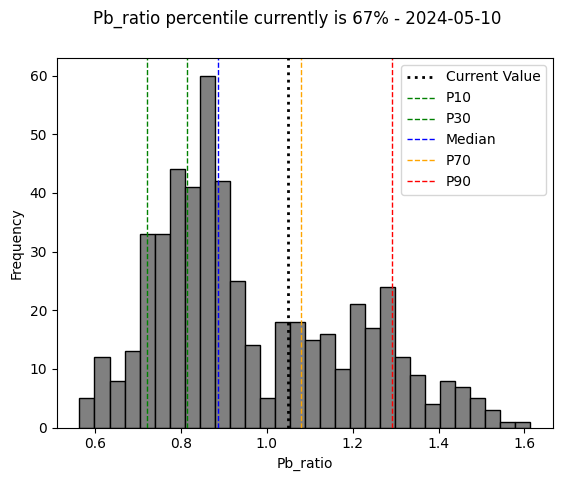

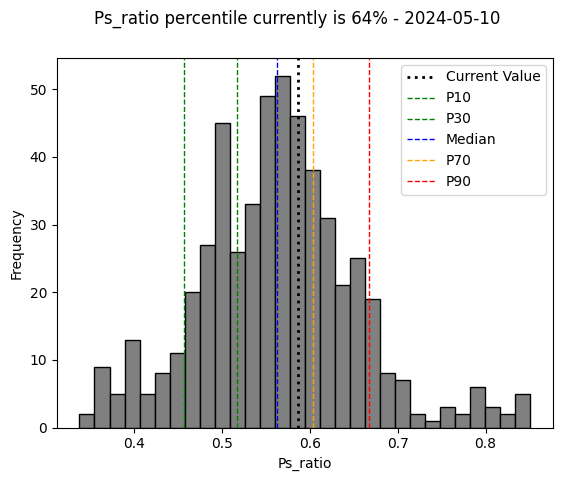

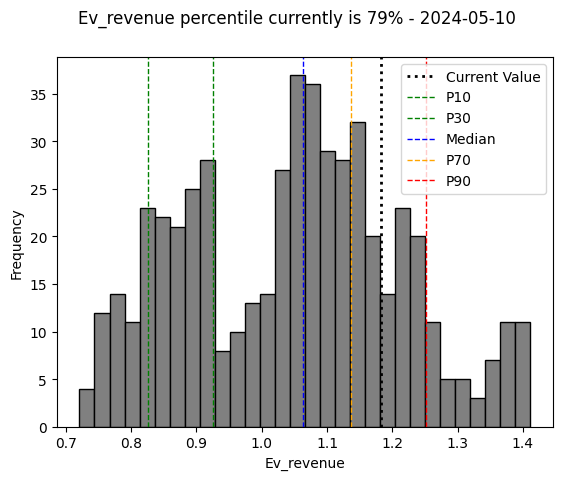

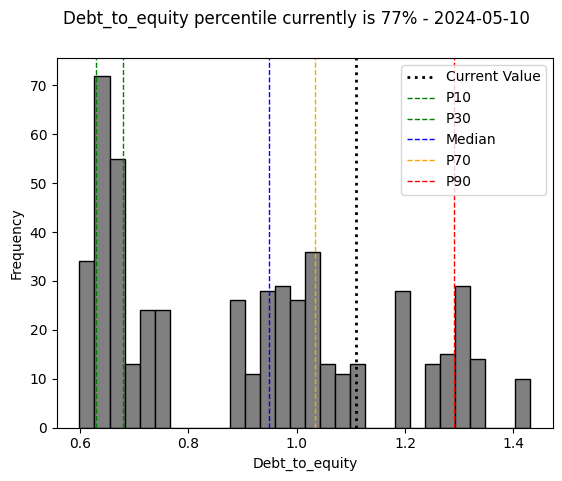

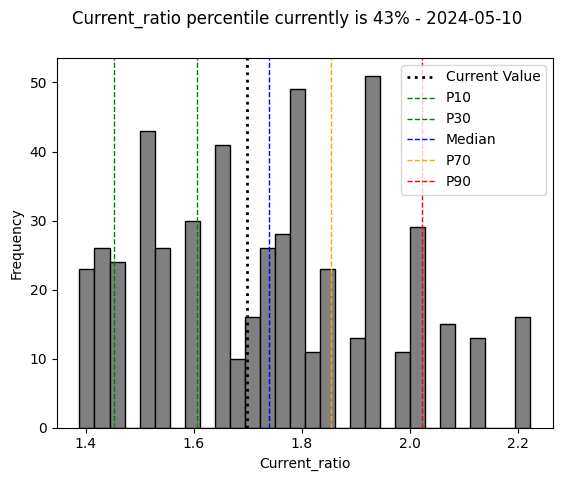

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.975684,-0.407792,0.188777,-0.332604,-0.428251,0.127208,0.394916
roe,0.975684,1.000000,-0.382158,0.346204,-0.360572,-0.419964,0.310875,0.281358
pe_ratio,-0.407792,-0.382158,1.000000,-0.027041,0.109632,0.210843,0.052902,-0.249249
pb_ratio,0.188777,0.346204,-0.027041,1.000000,0.068372,0.001328,0.826431,-0.321439
ps_ratio,-0.332604,-0.360572,0.109632,0.068372,1.000000,0.851574,-0.125132,0.089209
ev_revenue,-0.428251,-0.419964,0.210843,0.001328,0.851574,1.000000,0.104237,-0.134845
debt_to_equity,0.127208,0.310875,0.052902,0.826431,-0.125132,0.104237,1.000000,-0.438146
current_ratio,0.394916,0.281358,-0.249249,-0.321439,0.089209,-0.134845,-0.438146,1.000000


0 timestemos have been found!


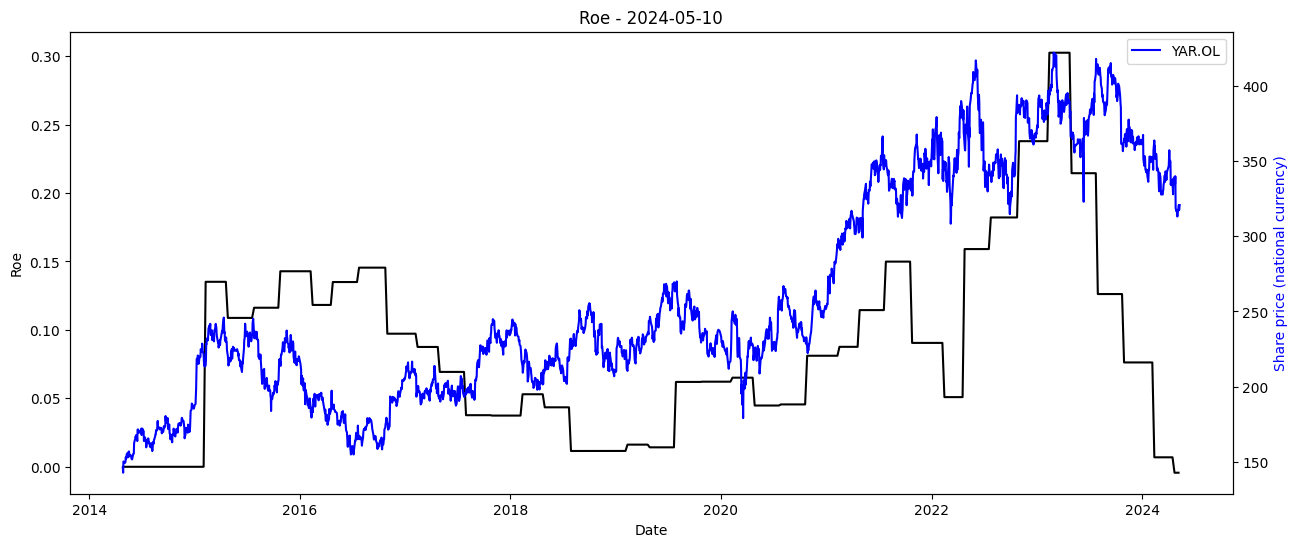

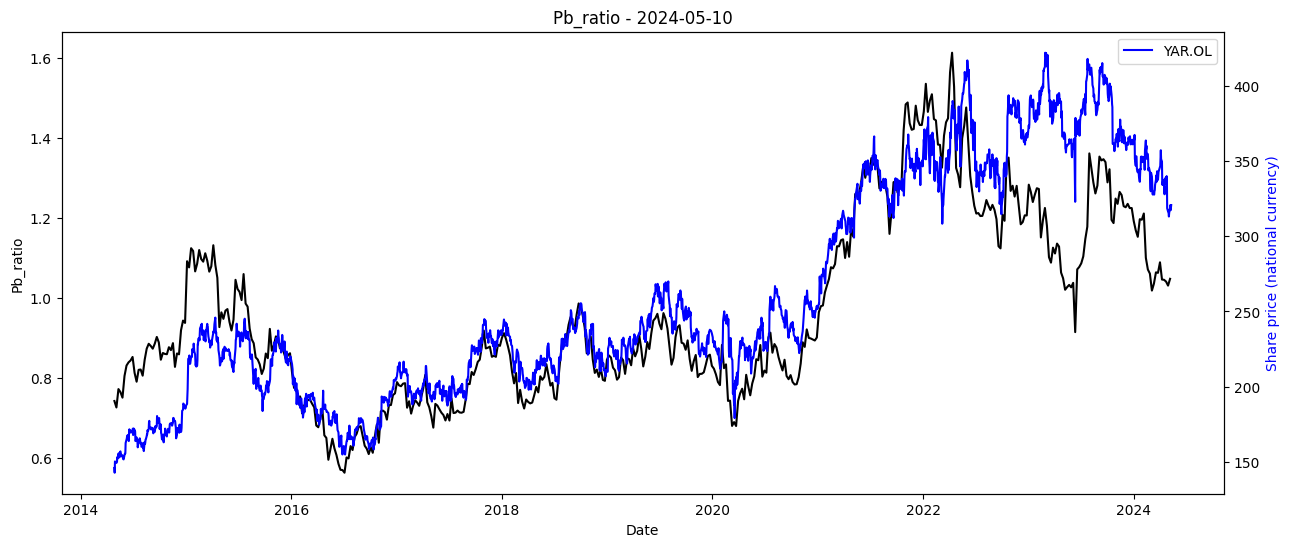

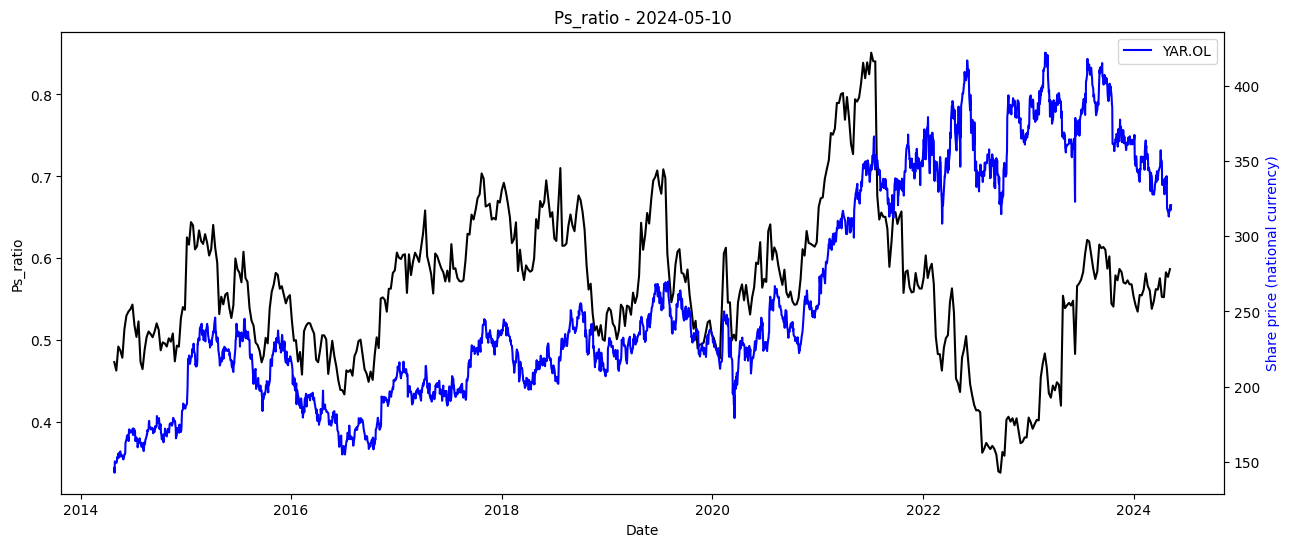

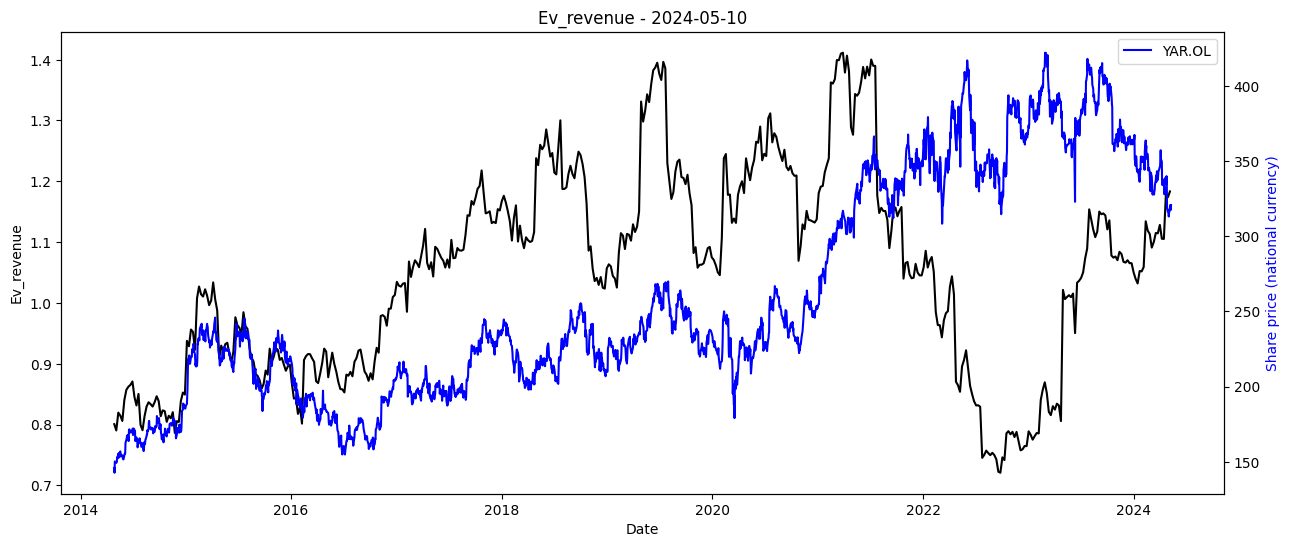

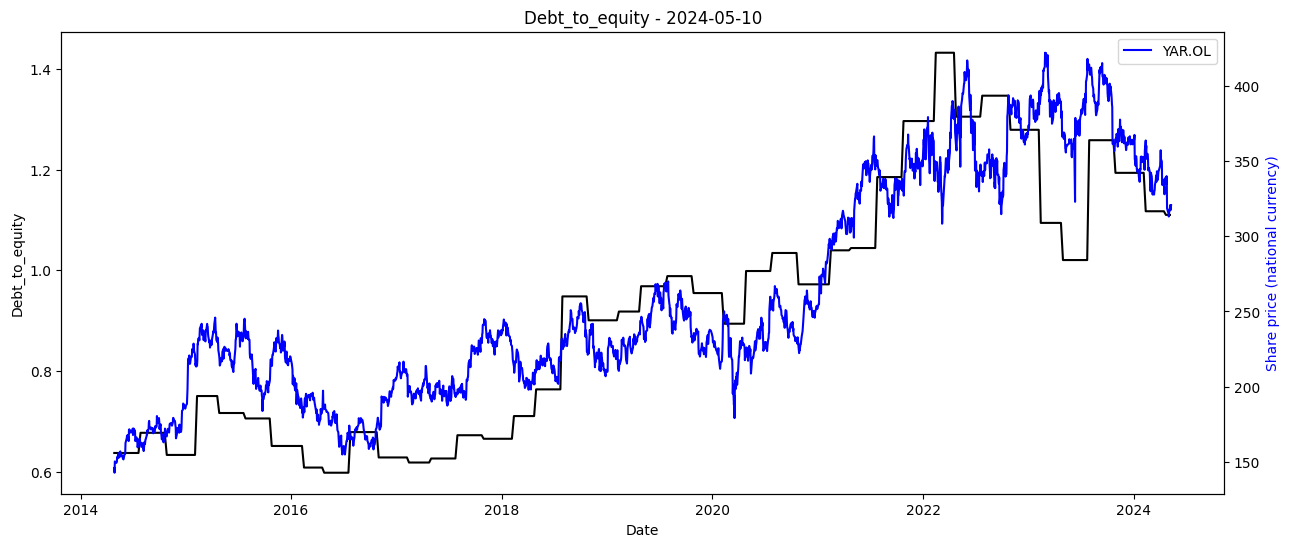

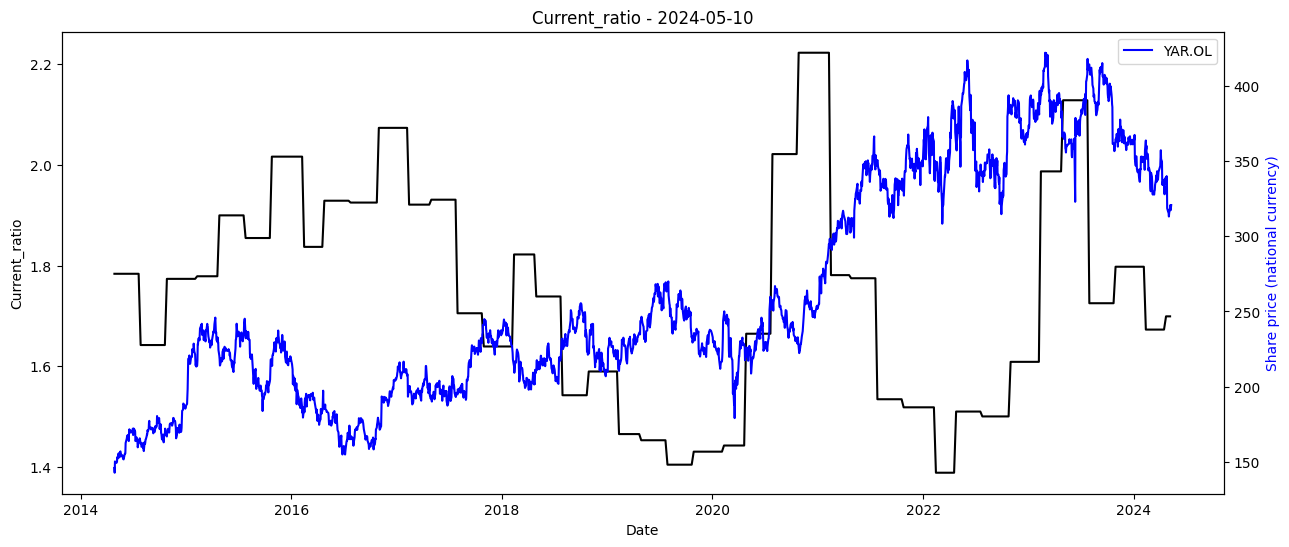

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )